# Data Curation

In [8]:
import os

import numpy as np

import SimpleITK as sitk
import pandas as pd

from concurrent.futures import ThreadPoolExecutor

from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

from ipywidgets import interact, widgets

# 1. Internal Population

#### Organizing Dataset

In [ ]:
DATA_DIR = r"C:\Users\sithi\Research\PhD Projects\prostate_analysis\data\processed\prostata"
OUT_DIR = r"C:\Users\sithi\Research\dataset\curated\INT_Prostate"

In [ ]:
SOI = ["t2w","adc","dce"]

In [ ]:
PIDS = os.listdir(os.path.join(DATA_DIR,SOI[0]))

In [ ]:
FILE_NAMES = {
    
    "t2w":{"img":"image","mask":"mask"},
    "adc":{"img":"adc", "mask":"adc_mask"},
    "dce":{"imgs":["sub_win","sub_wout"], "mask":"sub_mask"}
}

In [ ]:
NUM_WORKERS = 2

In [ ]:
def parse(pid):
    
    for sequence in SOI:
        
        data_dir = os.path.join(DATA_DIR, sequence, pid)
        data_dir = os.path.join(data_dir, sorted(os.listdir(data_dir))[0])
            
        if sequence!="dce":
            
            out_dir = os.path.join(OUT_DIR, pid, sequence)
            if not os.path.exists(out_dir):
                os.makedirs(out_dir)
        
            fname = FILE_NAMES[sequence]["img"]
            sitk_img = sitk.ReadImage(os.path.join(data_dir,f"{fname}.nrrd"))
            
            if sequence=="adc":
                
                img_origin, img_spacing, img_direction = sitk_img.GetOrigin(), sitk_img.GetSpacing(), sitk_img.GetDirection()
                img_arr = sitk.GetArrayFromImage(sitk_img)
                img_arr *= 10**6
                sitk_img = sitk.GetImageFromArray(np.rint(img_arr).astype(np.int32))
                sitk_img.SetOrigin(img_origin)
                sitk_img.SetSpacing(img_spacing)
                sitk_img.SetDirection(img_direction)
                
                
            
            sitk.WriteImage(sitk_img, os.path.join(out_dir, "img.nii.gz"))

            msk_name = FILE_NAMES[sequence]["mask"]
            sitk_mask = sitk.ReadImage(os.path.join(data_dir,f"{msk_name}.nrrd"))
            sitk.WriteImage(sitk_mask, os.path.join(out_dir, "mask.nii.gz"))
            
        else:
            
            
            for fname in FILE_NAMES[sequence]["imgs"]:
                
                out_dir = os.path.join(OUT_DIR, pid, fname)
                if not os.path.exists(out_dir):
                    os.makedirs(out_dir)
                
                sitk_img = sitk.ReadImage(os.path.join(data_dir,f"{fname}.nrrd"))
                sitk.WriteImage(sitk_img, os.path.join(out_dir, "img.nii.gz"))
                
                msk_name = FILE_NAMES[sequence]["mask"]
                sitk_mask = sitk.ReadImage(os.path.join(data_dir, f"{msk_name}.nrrd"))
                sitk.WriteImage(sitk_mask, os.path.join(out_dir, "mask.nii.gz"))
                
            
    pbar.update()
    

In [ ]:
pbar = tqdm(PIDS,desc="Processing records",position=0)
with ThreadPoolExecutor(max_workers=NUM_WORKERS) as e:e.map(parse, PIDS)

#### Dataset Distribution

In [ ]:
DATA_DIR = r"C:\Users\sithi\Research\dataset\curated\INT_Prostate"

SOI = ["t2w","adc","sub_win","sub_wout"]

In [ ]:
sample_pids = os.listdir(DATA_DIR)[:10]

In [ ]:
for sequence in SOI:
    
    print(f"****************For {sequence}*************")
    vmins = []
    vmaxs = []
    vmeans = []
    vstds = []
    
    for pid in sample_pids:
        
        img = sitk.ReadImage(os.path.join(DATA_DIR, pid, sequence, "img.nii.gz"))
        img_arr = sitk.GetArrayFromImage(img).ravel()
        
        plt.hist(img_arr,bins=100)
        plt.show()
        
        print(f"Min:{img_arr.min()}, Max:{img_arr.max()}, Mean:{img_arr.mean()}, Std:{img_arr.std()}")
        
        vmins.append(img_arr.min())
        vmaxs.append(img_arr.max())
        vmeans.append(img_arr.mean())
        vstds.append(img_arr.std())
        
    
    df = {"vmins":vmins, "vmaxs":vmaxs, "vmeans":vmeans, "vstds":vstds}
    df = pd.DataFrame.from_dict(df)
    
    display(df)
        
        
        
  
    

#### Voxel Spacing Distribution

In [15]:
DATA_DIR = r"C:\Users\sithi\Research\dataset\curated\INT_Prostate"

In [16]:
pids = os.listdir(DATA_DIR)

In [17]:
df_int = {"t2w":{"dw":[],"dh":[],"dz":[]},"adc":{"dw":[],"dh":[],"dz":[]},"sub_win":{"dw":[],"dh":[],"dz":[]},"sub_wout":{"dw":[],"dh":[],"dz":[]}}

In [18]:
for sequence in df_int:
    
    for pid in tqdm(pids, desc=f"processing for {sequence}", position=0):
        
        img = sitk.ReadImage(os.path.join(DATA_DIR,pid,sequence,"img.nii.gz"))
        
        dw, dh, dz = img.GetSpacing()
        
        df_int[sequence]["dw"] += [dw]
        df_int[sequence]["dh"] += [dh]
        df_int[sequence]["dz"] += [dz]
        
        

processing for sub_wout: 100%|███████████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.18it/s]


In [19]:
for sequence in df_int:
    
    df = pd.DataFrame.from_dict(df_int[sequence])

    median_spacing = df.dw.median().round(2),df.dh.median().round(2),df.dz.median().round(2)
    
    print(f"Median spacing for {sequence} is {median_spacing}")

Median spacing for t2w is (0.3, 0.3, 3.3)
Median spacing for adc is (1.25, 1.25, 3.3)
Median spacing for sub_win is (1.14, 1.14, 1.5)
Median spacing for sub_wout is (1.14, 1.14, 1.5)


#### Computing Global Mean and Std for Z-Score Computation for ADC

In [9]:
DATA_DIR = r"C:\Users\sithi\Research\dataset\curated\INT_Prostate"

In [3]:
pids = os.listdir(DATA_DIR)

In [174]:
adc_roi_values = []

for pid in tqdm(pids, desc=f"Parsing the range of adc maps", position=0):
    
    img = sitk.ReadImage(os.path.join(DATA_DIR, pid, "adc","img.nii.gz"))
    mask = sitk.ReadImage(os.path.join(DATA_DIR,pid,"adc","mask.nii.gz"))
    
    img_arr = sitk.GetArrayFromImage(img)
    mask_arr = sitk.GetArrayFromImage(mask)
    

    adc_roi_values += [img_arr[mask_arr==1]]
    

adc_roi_values = np.concatenate(adc_roi_values)

print(f"ADC mean = {np.rint(adc_roi_values.mean())}")
print(f"ADC std = {np.rint(adc_roi_values.std())}")
    

Parsing the range of adc maps: 100%|█████████████████████████████████████████████████| 100/100 [00:02<00:00, 48.30it/s]

ADC mean = 1159.0
ADC std = 270.0


# 2. External Population

#### Organizing Dataset

In [ ]:
DATA_DIR = r"C:\Users\sithi\Research\PhD Projects\prostate_analysis\data\processed\qin_prostata"
OUT_DIR = r"C:\Users\sithi\Research\dataset\curated\QIN_Prostate"

In [ ]:
SOI = ["t2w","adc","dce"]

In [ ]:
PIDS = os.listdir(os.path.join(DATA_DIR,SOI[0]))

In [ ]:
NUM_WORKERS = 2

In [ ]:
def parse(pid):
    
    for sequence in SOI:
        
        data_dir = os.path.join(DATA_DIR, sequence, pid)
        data_dir = os.path.join(data_dir, sorted(os.listdir(data_dir))[0])
 
        out_dir = os.path.join(OUT_DIR, pid, sequence if sequence!="dce" else "sub")
        if not os.path.exists(out_dir):
            os.makedirs(out_dir)

        sitk_img = sitk.ReadImage(os.path.join(data_dir,"image.nrrd"))
        sitk.WriteImage(sitk_img, os.path.join(out_dir, "img.nii.gz"))

        sitk_mask = sitk.ReadImage(os.path.join(data_dir,"mask.nrrd"))
        sitk.WriteImage(sitk_mask, os.path.join(out_dir, "mask.nii.gz"))
            
       
                
            
    pbar.update()
    

In [ ]:
pbar = tqdm(PIDS,desc="Processing records",position=0)
with ThreadPoolExecutor(max_workers=NUM_WORKERS) as e:e.map(parse, PIDS)

#### Dataset Distribution

In [ ]:
DATA_DIR = r"C:\Users\sithi\Research\dataset\curated\QIN_Prostate"

SOI = ["t2w","adc","sub"]

In [ ]:
sample_pids = os.listdir(DATA_DIR)[:10]

In [ ]:
for sequence in SOI:
    
    print(f"****************For {sequence}*************")
    vmins = []
    vmaxs = []
    vmeans = []
    vstds = []
    
    for pid in sample_pids:
        
        img = sitk.ReadImage(os.path.join(DATA_DIR, pid, sequence, "img.nii.gz"))
        img_arr = sitk.GetArrayFromImage(img).ravel()
        
        plt.hist(img_arr,bins=100)
        plt.show()
        
        print(f"Min:{img_arr.min()}, Max:{img_arr.max()}, Mean:{img_arr.mean()}, Std:{img_arr.std()}")
        
        vmins.append(img_arr.min())
        vmaxs.append(img_arr.max())
        vmeans.append(img_arr.mean())
        vstds.append(img_arr.std())
        
    
    df = {"vmins":vmins, "vmaxs":vmaxs, "vmeans":vmeans, "vstds":vstds}
    df = pd.DataFrame.from_dict(df)
    
    display(df)
        
        
        
  
    

#### Voxel Spacing Distribution

In [20]:
DATA_DIR = r"C:\Users\sithi\Research\dataset\curated\QIN_Prostate"

In [21]:
pids = os.listdir(DATA_DIR)

In [22]:
df_ext = {"t2w":{"dw":[],"dh":[],"dz":[]},"adc":{"dw":[],"dh":[],"dz":[]},"sub":{"dw":[],"dh":[],"dz":[]}}

In [23]:
for sequence in df_ext:
    
    for pid in tqdm(pids, desc=f"processing for {sequence}", position=0):
        
        img = sitk.ReadImage(os.path.join(DATA_DIR,pid,sequence,"img.nii.gz"))
        
        dw, dh, dz = img.GetSpacing()
        
        df_ext[sequence]["dw"] += [dw]
        df_ext[sequence]["dh"] += [dh]
        df_ext[sequence]["dz"] += [dz]
        
        

processing for sub: 100%|██████████████████████████████████████████████████████████████| 15/15 [00:01<00:00, 14.31it/s]


In [34]:
for sequence in df_ext:
    
    df = pd.DataFrame.from_dict(df_ext[sequence])

    median_spacing = df.dw.median().round(2),df.dh.median().round(2),df.dz.median().round(2)
    
    print(f"Median spacing for {sequence} is {median_spacing}")

Median spacing for t2w is (0.27, 0.27, 3.5)
Median spacing for adc is (0.7, 0.7, 4.0)
Median spacing for sub is (0.55, 0.55, 2.5)


In [46]:
adc_ext = {"min":[],"max":[]}

for pid in tqdm(pids, desc=f"Parsing the range of adc maps", position=0):
    
    img = sitk.ReadImage(os.path.join(DATA_DIR, pid, "adc","img.nii.gz"))
    
    img_arr = sitk.GetArrayFromImage(img)

    
    adc_ext["min"] += [img_arr.min()]
    adc_ext["max"] += [img_arr.max()]

Parsing the range of adc maps: 100%|███████████████████████████████████████████████████| 15/15 [00:00<00:00, 47.57it/s]


In [53]:
import matplotlib.pyplot as plt

(array([8., 0., 0., 0., 0., 0., 0., 0., 0., 7.]),
 array([-256. , -230.4, -204.8, -179.2, -153.6, -128. , -102.4,  -76.8,
         -51.2,  -25.6,    0. ]),
 <BarContainer object of 10 artists>)

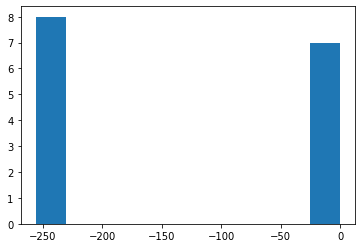

In [55]:
plt.hist(adc_ext["min"])

In [62]:
min(adc_ext["min"]),max(adc_ext["max"])

(-256, 5565)

##### Internal Population Median Spacing

- Median spacing for t2w is (0.3, 0.3, 3.3)
- Median spacing for adc is (1.25, 1.25, 3.3)
- Median spacing for sub_win is (1.14, 1.14, 1.5)
- Median spacing for sub_wout is (1.14, 1.14, 1.5)

###### External Population Median Spacing
- Median spacing for t2w is (0.27, 0.27, 3.5)
- Median spacing for adc is (0.7, 0.7, 4.0)
- Median spacing for sub is (0.55, 0.55, 2.5) 


##### Range of ADC Map

Internal: (0, 3038)
External: (0, 5565)